# Titanic Exploring

A survey to the [titanic data set](https://www.kaggle.com/c/titanic).

```
Author  : Minh Hoang and Quang Nguyen
Version : 0.0.1
```

In the box below, this piece of code I found online includes various helper functions for ploting. The author of the code is Helge Bjorland. This work is inspired by Mr. Bjorland and fitted for my first lab assignment.

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) )
        # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame(
        model.feature_importances_  ,
        columns = [ 'Importance' ] ,
        index = X.columns
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Filtering data

In [4]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

full = train.append( test , ignore_index = True )
del train , test

full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


Using Weka, we can see that the features passengerId, name, and ticket have a uniqueness of 100%, 100%, and 61% respectively. Thus, they do not provide much insight, and we decide to remove them from the dataset. Also, Weka treats the survival attribute as numeric instead of nominal. We must write a script to change 0 to Die, and 1 to live.

In [5]:
del full['PassengerId']
del full['Name']
del full['Ticket']

titanic = full[ :891 ]

titanic.head()

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,NaN,S,7.2500,0,3,male,1,0.0
1,38.0,C85,C,71.2833,0,1,female,1,1.0
2,26.0,NaN,S,7.9250,0,3,female,0,1.0
3,35.0,C123,S,53.1000,0,1,female,1,1.0
4,35.0,NaN,S,8.0500,0,3,male,0,0.0


## Exploring data

### [ZeroR](http://machinelearningmastery.com/implement-baseline-machine-learning-algorithms-scratch-python/)

According to Weka, we have 549 deaths and 342 survived people. So, for every person, we predict that they will die, the accuracy of our ZeroR model would be: 549 / 891 = 61.61%

Let's this be our baseline model and our future work should always beat this accuracy.

### [OneR](http://www.saedsayad.com/oner.htm)

OneR is all about choosing the the one rule. One ring to rule them all! Weka has already implemented the algorithm. So, we just need to use it. However, the OneR requires nominal attribute. Sadly, our the survived feature in our data set is represented as either 1 or 0. Sadly, Weka mistakenly takes this as numeric feature.

After filtering, Weka returns 78.68%

```
Sex:
    female -> Live
    male -> Die (701/891 instances correct)
```

### [J48](http://weka.sourceforge.net/doc.dev/weka/classifiers/trees/J48.html)

Accuracy: 80.47%

### [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

Accuracy: 77.89%

## Conclusion
J48 is the best algorithm out of the four. However, it is not so much faster than our simple OneR. Lastly, Naïve Bayes is only more accurate than our baseline model. Maybe this is because Naïve Bayes performs on independent features while our attributes are correlated to each other.

## Further analysis

Anyway, it's fairly easy to say that when the boat was sinking, people prioritize woman and children.

In [7]:
AGE_THRESHOLD = 17 # below = live! That's how life work. LOL

surviveCount = 0
surviveFemaleCount = 0
totalSurvive = 0

for i in range(len(titanic)):
    if (titanic['Sex'][i] == 'female' or titanic['Age'][i] <= AGE_THRESHOLD) and titanic['Survived'][i] == 1:
        surviveCount += 1
    if titanic['Survived'][i] == 1:
        totalSurvive += 1
        
for i in range(len(titanic)):
    if titanic['Sex'][i] == 'female' and titanic['Survived'][i] == 1:
        surviveFemaleCount += 1
        
print("Prioritize woman and children: {:.2f}%".format(surviveCount / totalSurvive * 100))
print("Prioritize only woman: {:.2f}%".format(surviveFemaleCount / totalSurvive * 100))

Prioritize woman and children: 74.85%
Prioritize only woman: 68.13%


Our hypothesis was a bit ad hoc, random. We need to look into the problem in a more systematic way. Thus, we can plot out a heat map to see the correlations between all features in our data set.

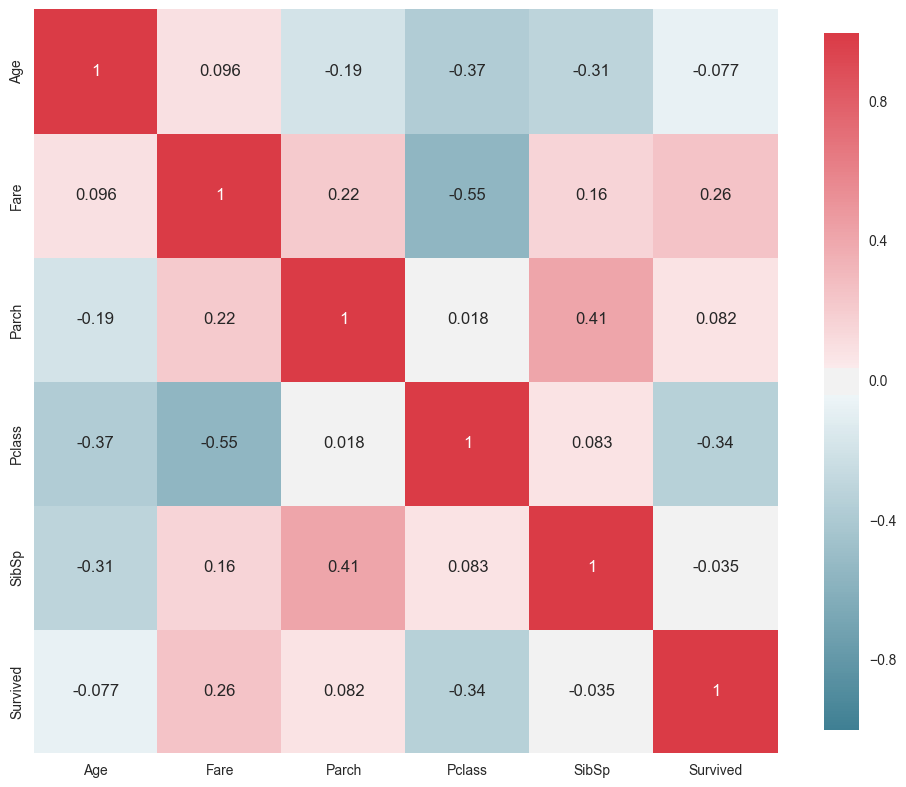

In [34]:
plot_correlation_map(titanic)

Here are some correlations we notice right away:
- Parch and SibSp
- Pclass and Fare
- Pclass and Age

These are pretty self explainatory. The more "vip" the person is, the ticket fare should also goes up. Similarly, the older the person is, the weathier they are. We are more interested in the last row, how survival rate correlated with other features:
- Survived and Age
- Survived and Fare
- Survived and Pclass
- Survived and Embarked

_Note that Fare and Pclass is correlated, so we just need to choose either one._

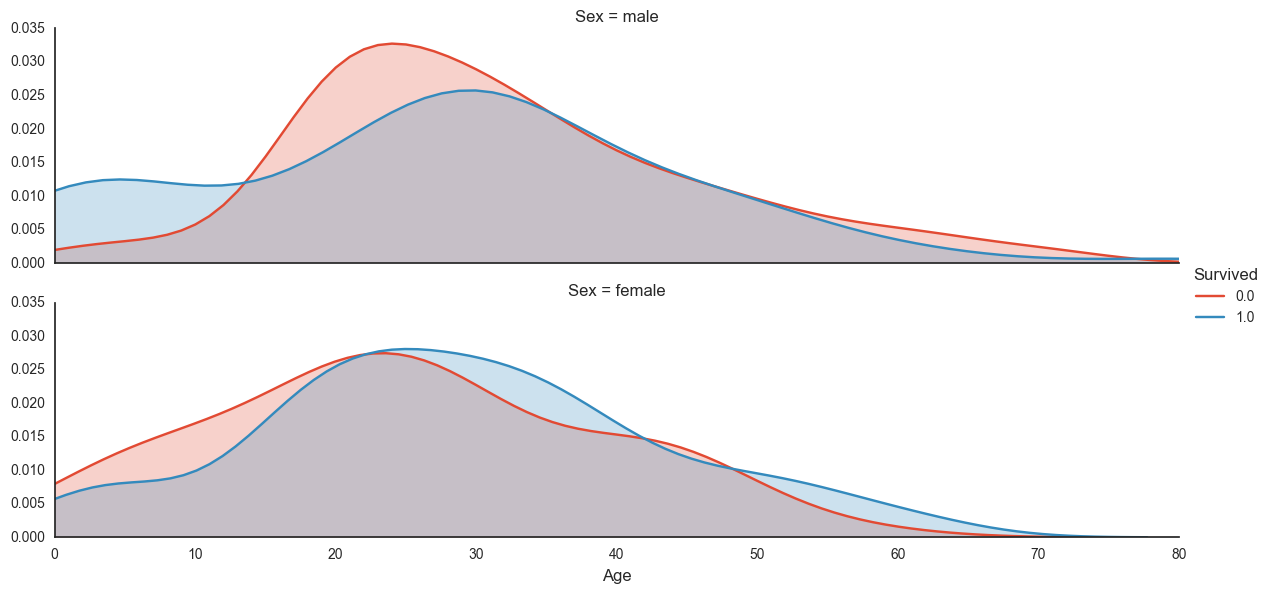

In [35]:
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

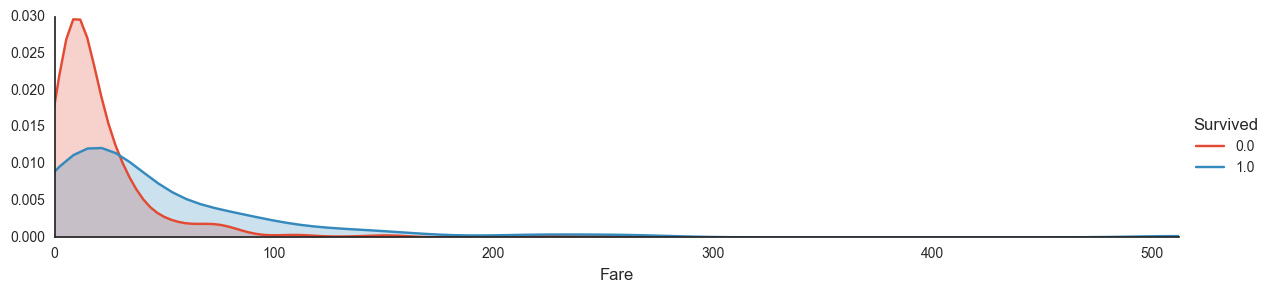

In [36]:
plot_distribution( titanic , var = 'Fare' , target = 'Survived')

[Kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation) plots are good way to visualize the number of deaths and survives on certain metric. But, we can also generate a bunch of bar plots to get more insights of the data. These plots can be generated in Weka, but for the sake of consistancy, I am going to generate them here.

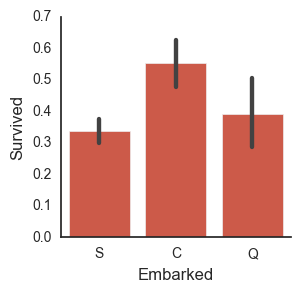

In [37]:
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

- C = Cherbourg
- Q = Queenstown
- S = Southampton

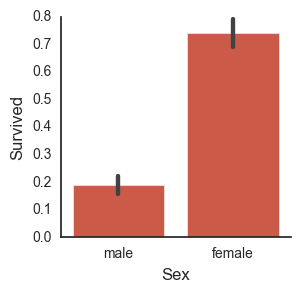

In [38]:
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

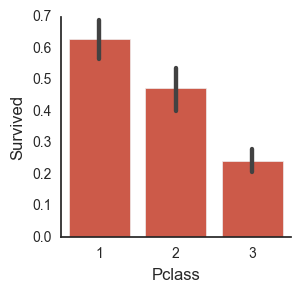

In [39]:
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

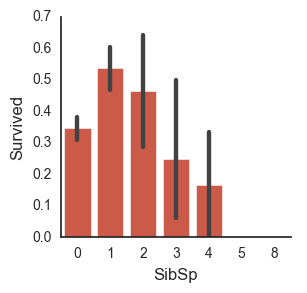

In [40]:
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

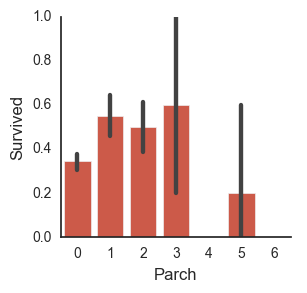

In [41]:
plot_categories( titanic , cat = 'Parch' , target = 'Survived' )

## Transforming data

In [42]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [43]:
# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [44]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [45]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [46]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [47]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [49]:
# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin , ticket

full_X = pd.concat( [ imputed , embarked , cabin , sex ] , axis=1 )
full_X.head()

,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Sex
0,22.0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1,1
1,38.0,71.2833,1,0,0,0,0,1,0,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,0,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,0,0,1,0,0,1,0,0,0,0,0,0,0
4,35.0,8.0500,0,0,1,0,0,0,0,0,0,0,0,1,1


In [50]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(1309, 15) (623, 15) (268, 15) (623,) (268,) (418, 15)


0.988764044944


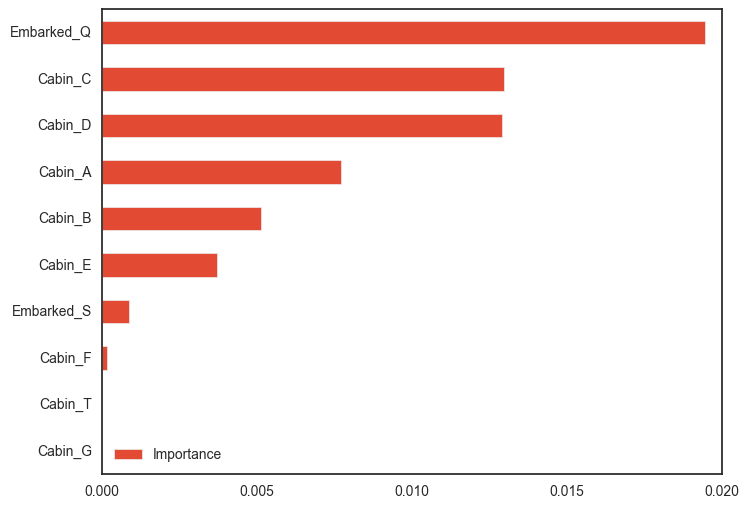

In [51]:
plot_variable_importance(train_X, train_y)